<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/ON4_RapidAPI_Hourly_Histogram_v3A_WIDGET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd

In [2]:


# @title Markov Markowitz Company / Portfolio Analyzer v3 { vertical-output: true }
# @markdown ---
# @markdown Input parameters for asset selection


EXCHANGE = "bist30"  # @param ['bist30', 'bist100', 'dow30', 'sp500']
INTERVAL = "1h"  # @param ['1m', '5m', '15m', '30m', '1h', '6h', '1d', '1mo', '3mo']
PERIOD = "6mo"  # @param ['1m', '5m', '15m', '30m', '1h', '6h', '1mo', '3mo', '6mo', '1Y', 'ytd']


# @markdown ---



In [3]:


def GetSelectedStockList(exchange):

    from google.colab import files

    filename = f"Best_PF_For_{exchange}.csv"

    files.upload_file(filename)

    stock_list = pd.read_csv(filename).assets
    print(stock_list)
    return(stock_list)



In [4]:
def PlotHistogramOf(ticker):


    url = f"https://yahoo-finance127.p.rapidapi.com/historic/{ticker}/{INTERVAL}/{PERIOD}"

    headers = {
      "X-RapidAPI-Key": "c4100a6817msh6100fdd804b1ae8p1defa4jsn72757c98b3c0",
      "X-RapidAPI-Host": "yahoo-finance127.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
      data = response.json()
      # Extract the "close" data
      close_data = data['indicators']['quote'][0]['close']

    timestamps = data["timestamp"]

    # Convert timestamps to datetime
    timestamps = [pd.to_datetime(ts, unit="s") for ts in timestamps]
    timestamps = [ts + pd.Timedelta(minutes=150) for ts in timestamps]

    # Create a DataFrame
    # df = pd.DataFrame({"Date-Time": timestamps, "Close": close_data})
    df = pd.DataFrame({"Close": close_data}, index=timestamps)

    # df[df.index >"2023-08-18 00:00:00"]
    # Create an empty list to store the split DataFrames
    split_dataframes = []

    # Define the start and end times
    start_time = pd.to_datetime("08:30:00").time()
    end_time = pd.to_datetime("19:00:00").time()

    # Iterate through the DataFrame and split it
    for date in df.index.to_series().dt.date.unique():
        daily_data = df[df.index.to_series().dt.date == date]  # Filter data for the current date

        # Filter data for the specified time range
        daily_data = daily_data[(daily_data.index.time >= start_time) & (daily_data.index.time <= end_time)]

        if not daily_data.empty:
            split_dataframes.append(daily_data)

    # Print the split DataFrames
    # for i, split_df in enumerate(split_dataframes):
    #     print(f"DataFrame {i + 1}:\n{split_df}\n")

    import numpy as np

    # Create empty lists to store peak and lowest price information
    peak_hours = []
    lowest_hours = []
    peak_prices = []
    lowest_prices = []

    # Iterate through the split DataFrames
    for split_df in split_dataframes:
        # Find the timestamp with the maximum price
        max_price_timestamp = split_df["Close"].idxmax()
        max_price = split_df["Close"].max()

        # Find the timestamp with the lowest price
        min_price_timestamp = split_df["Close"].idxmin()
        min_price = split_df["Close"].min()

        # Append the information to the respective lists
        peak_hours.append(max_price_timestamp)
        lowest_hours.append(min_price_timestamp)
        peak_prices.append(max_price)
        lowest_prices.append(min_price)

    # Find the overall peak and lowest prices and their corresponding hours
    overall_peak_index = np.argmax(peak_prices)
    overall_lowest_index = np.argmin(lowest_prices)

    overall_peak_hour = peak_hours[overall_peak_index]
    overall_lowest_hour = lowest_hours[overall_lowest_index]
    overall_peak_price = peak_prices[overall_peak_index]
    overall_lowest_price = lowest_prices[overall_lowest_index]

    #print(f"Overall Peak Price: {overall_peak_price} at {overall_peak_hour}")
    #print(f"Overall Lowest Price: {overall_lowest_price} at {overall_lowest_hour}")
    # Create an empty list to store results
    results = []

    # Iterate through the split DataFrames
    for i, split_df in enumerate(split_dataframes):
        # Find the timestamp with the highest and lowest prices
        peak_timestamp = split_df['Close'].idxmax()
        lowest_timestamp = split_df['Close'].idxmin()

        # Extract the corresponding prices
        peak_price = split_df['Close'].loc[peak_timestamp]
        lowest_price = split_df['Close'].loc[lowest_timestamp]

        # Append the results for this piece of data to the list
        results.append({
            'DataFrame': i + 1,
            'Peak Hour': peak_timestamp,
            'Peak Price': peak_price,
            'Lowest Hour': lowest_timestamp,
            'Lowest Price': lowest_price
        })

    # Convert the results list to a DataFrame for better presentation
    results_df = pd.DataFrame(results)

    # Print the results
    #print(results_df)

    import matplotlib.pyplot as plt

    # Create histograms for peak hours and lowest hours
    plt.figure(figsize=(12, 3))

    # Histogram for peak hours
    plt.subplot(1, 2, 1)
    plt.hist(results_df['Peak Hour'].dt.hour, bins=range(0, 24), rwidth=0.8, alpha=0.7)
    plt.title(f"Peak Hours Frequency for {ticker}")
    plt.xlabel('Hour')
    plt.ylabel('Frequency')
    plt.xticks(range(0, 24))
    plt.grid(axis='y')

    # Histogram for lowest hours
    plt.subplot(1, 2, 2)
    plt.hist(results_df['Lowest Hour'].dt.hour,bins=range(0, 24), rwidth=0.8, alpha=0.7)
    plt.title(f"Lowest Hours Frequency for {ticker}")
    plt.xlabel('Hour')
    plt.ylabel('Frequency')
    plt.xticks(range(0, 24))
    plt.grid(axis='y')

    # Adjust spacing between subplots
    plt.tight_layout()

    best_buy_hours = []
    best_sell_hours = []

    for split_df in split_dataframes:
        # Find the timestamp with the lowest and highest prices
        lowest_timestamp = split_df['Close'].idxmin()
        peak_timestamp = split_df['Close'].idxmax()

        best_buy_hours.append(lowest_timestamp)
        best_sell_hours.append(peak_timestamp)

    # Create a DataFrame to store the results
    best_hours_df = pd.DataFrame({
        'Date': [hour.date() for hour in best_buy_hours],
        'Asset': ticker,
        'Best Buy Hour': best_buy_hours,
        'Best Sell Hour': best_sell_hours
    })

    # Show the histograms
    plt.show()

    return best_hours_df





Saved Best_PF_For_bist30.csv to /content/Best_PF_For_bist30.csv
0    ENKAI.IS
1    KOZAL.IS
2    ISCTR.IS
3    AKBNK.IS
4    GUBRF.IS
Name: assets, dtype: object


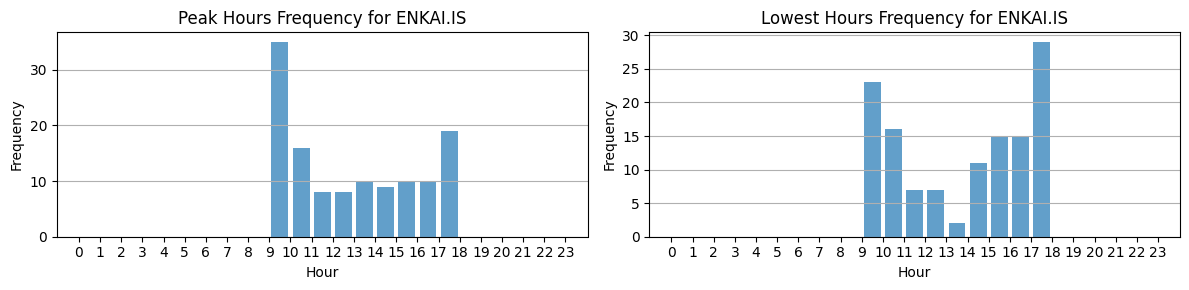

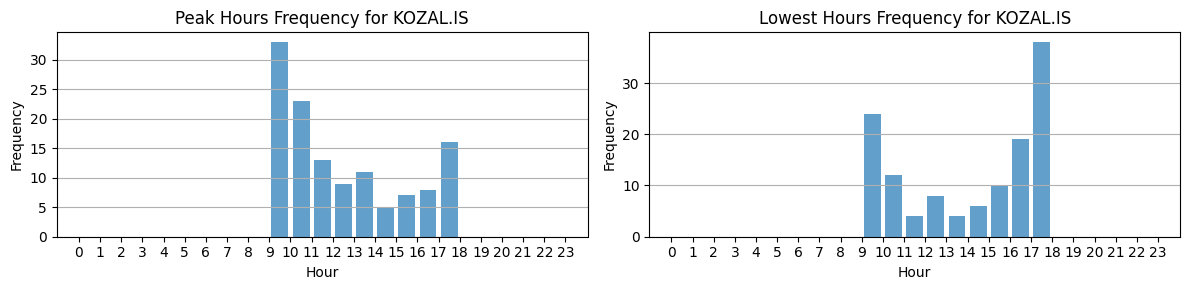

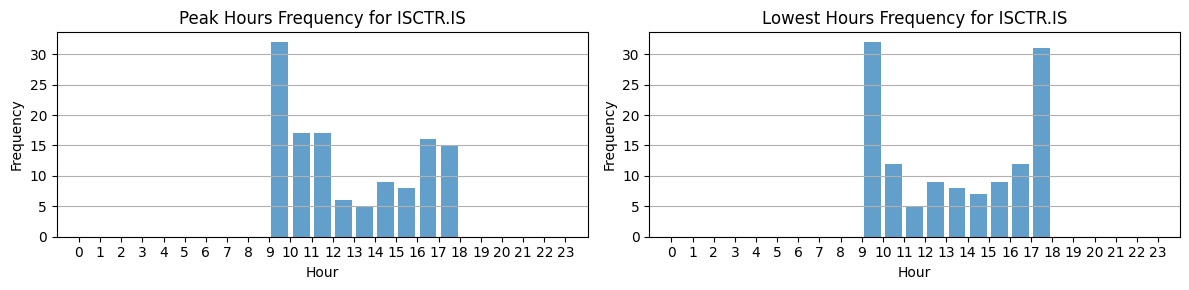

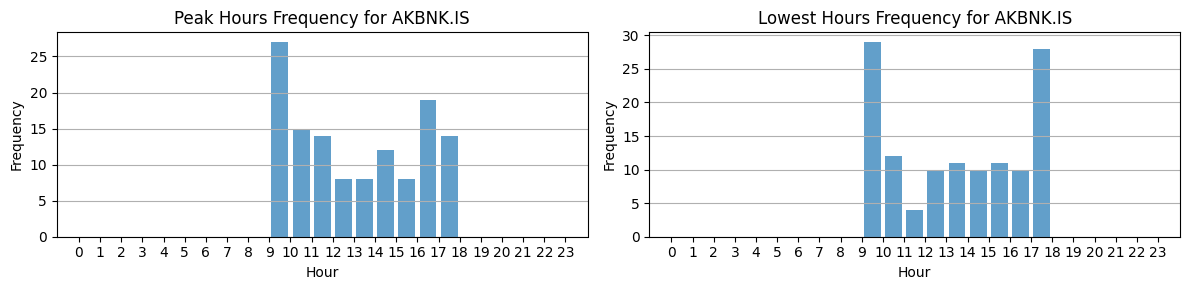

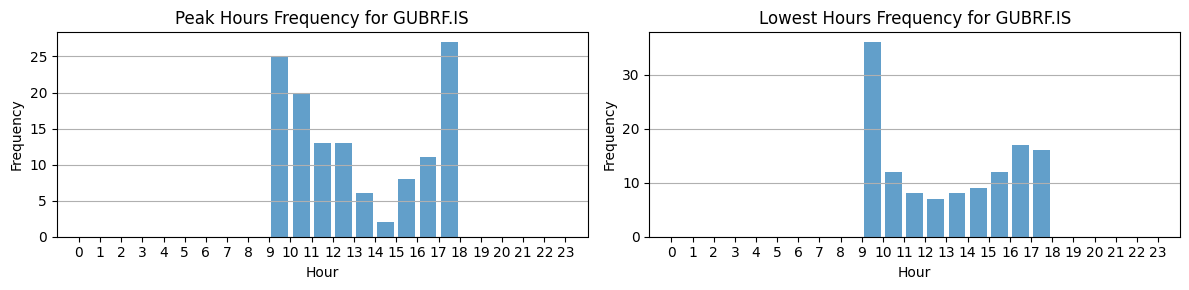

           Date     Asset       Best Buy Hour      Best Sell Hour
0    2023-03-13  ENKAI.IS 2023-03-13 14:00:00 2023-03-13 10:00:00
1    2023-03-14  ENKAI.IS 2023-03-14 16:00:00 2023-03-14 09:00:00
2    2023-03-15  ENKAI.IS 2023-03-15 13:00:00 2023-03-15 09:00:00
3    2023-03-16  ENKAI.IS 2023-03-16 15:00:00 2023-03-16 10:00:00
4    2023-03-17  ENKAI.IS 2023-03-17 09:00:00 2023-03-17 10:00:00
..          ...       ...                 ...                 ...
120  2023-09-06  GUBRF.IS 2023-09-06 15:00:00 2023-09-06 10:00:00
121  2023-09-07  GUBRF.IS 2023-09-07 12:00:00 2023-09-07 13:00:00
122  2023-09-08  GUBRF.IS 2023-09-08 10:00:00 2023-09-08 15:00:00
123  2023-09-11  GUBRF.IS 2023-09-11 17:00:00 2023-09-11 11:00:00
124  2023-09-12  GUBRF.IS 2023-09-12 10:00:00 2023-09-12 09:00:00

[625 rows x 4 columns]


In [5]:
exchange = EXCHANGE
stock_list = GetSelectedStockList(exchange)

all_best_hours_df = pd.DataFrame(columns=['Date', 'Asset', 'Best Buy Hour', 'Best Sell Hour'])

# Iterate through BEST30 assets and collect best hours data
for ticker in stock_list:
  best_hours_df = PlotHistogramOf(ticker)
  all_best_hours_df = pd.concat([all_best_hours_df, best_hours_df])

# Display the best hours data for buying and selling for all assets
print(all_best_hours_df)

In [6]:
# # ///////////////////////////////////////////////////////////
# # FUNCTIONS FOR ALPHA VANTAGE
# # ///////////////////////////////////////////////////////////
# TIME_SERIES_INTRADAY = 'TIME_SERIES_INTRADAY'
# TIME_SERIES_INTRADAY_EXTENDED = 'TIME_SERIES_INTRADAY_EXTENDED'
# TIME_SERIES_DAILY = 'TIME_SERIES_DAILY'
# TIME_SERIES_DAILY_ADJUSTED = 'TIME_SERIES_DAILY_ADJUSTED'
# TIME_SERIES_WEEKLY = 'TIME_SERIES_WEEKLY'
# TIME_SERIES_WEEKLY_ADJUSTED = 'TIME_SERIES_WEEKLY_ADJUSTED'
# TIME_SERIES_MONTHLY = 'TIME_SERIES_MONTHLY'
# TIME_SERIES_MONTHLY_ADJUSTED = 'TIME_SERIES_MONTHLY_ADJUSTED'

# # ///////////////////////////////////////////////////////////
# # TIME SERIES FOR STOCK DATA
# # ///////////////////////////////////////////////////////////
# ONEMIN = 'Time Series (1min)'
# FIVEMIN = 'Time Series (5min)'
# FIVETEENMIN = 'Time Series (15min)'
# THIRTYMIN = 'Time Series (30min)'
# HOUR = 'Time Series (60min)'
# FIVEMIN = 'Time Series (5min)'
# DAILY = 'Time Series (Daily)'
# WEEKLY = 'Weekly Time Series'
# WEEKLY_ADJ = 'Weekly Adjusted Time Series'
# MONTLY = 'Monthly Time Series'
# MONTLY_ADJ = 'Monthly Adjusted Time Series'

# # /////////////////////////////////////////////////////////
# # query timeseries stock data of selected type ////////////
# # /////////////////////////////////////////////////////////
# def query_timeseries_data(func, symbol, outputsize='full', datatype='json', apikey='AN5SOF59K41U0YQ3'):
#     data = {
#         "function": func, # Here you can put any of the 'funcs' above
#         "symbol": symbol,
#         "outputsize": outputsize, # (full) and (compact) are accepted
#         "datatype": datatype,
#         "apikey": apikey
#     }
#     return requests.get("https://www.alphavantage.co/query", data).json()

# # /////////////////////////////////////////////////////////
# # convert timeseries stock data of selected type to json //
# # /////////////////////////////////////////////////////////
# def get_timeseries_dataframe(json, type):
#     df = pd.DataFrame.from_dict(json[type], orient= 'index')
#     df.index =  pd.to_datetime(df.index, format='%Y-%m-%d')

#     df = df.rename(columns={ '1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. volume': 'Volume'})
#     df = df.astype({'Open': 'float64', 'High': 'float64', 'Low': 'float64','Close': 'float64','Volume': 'float64',})
#     df = df[[ 'Open', 'High', 'Low', 'Close', 'Volume']]
#     return df

# # Now all you have to do is actually call the funcs
# response_json = query_timeseries_data(TIME_SERIES_DAILY, 'MSFT')
# stockprice_dataframe = get_timeseries_dataframe(response_json, DAILY)
# stockprice_dataframe